# Machine Learning Assignment 2: An Investigation Into New York City Taxi Trip Dataset

Wenqu Tang
MSc in Virtual Reality

New York City Yellow Taxi Trip Records(January, 2024)
Dataset link: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

# Load the Data

In [342]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, Point, MultiPolygon
from sklearn.model_selection import train_test_split
import time
import datetime
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [144]:
# Load the data


raw_df = pd.read_parquet('E:/Goldsmiths/machinelearning/yellow_tripdata_2024-01.parquet', engine='pyarrow')

In [4]:
raw_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [5]:
raw_df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,2.964624e+06,2964624,2964624,2.824462e+06,2.964624e+06,2.824462e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.824462e+06,2.824462e+06
mean,1.754204e+00,2024-01-17 00:46:36.431092,2024-01-17 01:02:13.208130,1.339281e+00,3.652169e+00,2.069359e+00,1.660179e+02,1.651167e+02,1.161271e+00,1.817506e+01,1.451598e+00,4.833823e-01,3.335870e+00,5.270212e-01,9.756319e-01,2.680150e+01,2.256122e+00,1.411611e-01
min,1.000000e+00,2002-12-31 22:59:39,2002-12-31 23:05:41,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-8.990000e+02,-7.500000e+00,-5.000000e-01,-8.000000e+01,-8.000000e+01,-1.000000e+00,-9.000000e+02,-2.500000e+00,-1.750000e+00
25%,2.000000e+00,2024-01-09 15:59:19.750000,2024-01-09 16:16:23,1.000000e+00,1.000000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.538000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2024-01-17 10:45:37.500000,2024-01-17 11:03:51.500000,1.000000e+00,1.680000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.700000e+00,0.000000e+00,1.000000e+00,2.010000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2024-01-24 18:23:52.250000,2024-01-24 18:40:29,1.000000e+00,3.110000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.050000e+01,2.500000e+00,5.000000e-01,4.120000e+00,0.000000e+00,1.000000e+00,2.856000e+01,2.500000e+00,0.000000e+00
max,6.000000e+00,2024-02-01 00:01:15,2024-02-02 13:56:52,9.000000e+00,3.127223e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,5.000000e+03,1.425000e+01,4.000000e+00,4.280000e+02,1.159200e+02,1.000000e+00,5.000000e+03,2.500000e+00,1.750000e+00
std,4.325902e-01,NaN,NaN,8.502817e-01,2.254626e+02,9.823219e+00,6.362391e+01,6.931535e+01,5.808686e-01,1.894955e+01,1.804102e+00,1.177600e-01,3.896551e+00,2.128310e+00,2.183645e-01,2.338558e+01,8.232747e-01,4.876239e-01


In [20]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [219]:
# Systematically sample the data to make a smaller dataset
interval = 100
indices = np.arange(0, len(raw_df), interval)
df = raw_df.iloc[indices]

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29647 entries, 0 to 2964600
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               29647 non-null  int32         
 1   tpep_pickup_datetime   29647 non-null  datetime64[us]
 2   tpep_dropoff_datetime  29647 non-null  datetime64[us]
 3   passenger_count        28245 non-null  float64       
 4   trip_distance          29647 non-null  float64       
 5   RatecodeID             28245 non-null  float64       
 6   store_and_fwd_flag     28245 non-null  object        
 7   PULocationID           29647 non-null  int32         
 8   DOLocationID           29647 non-null  int32         
 9   payment_type           29647 non-null  int64         
 10  fare_amount            29647 non-null  float64       
 11  extra                  29647 non-null  float64       
 12  mta_tax                29647 non-null  float64       
 13  tip_

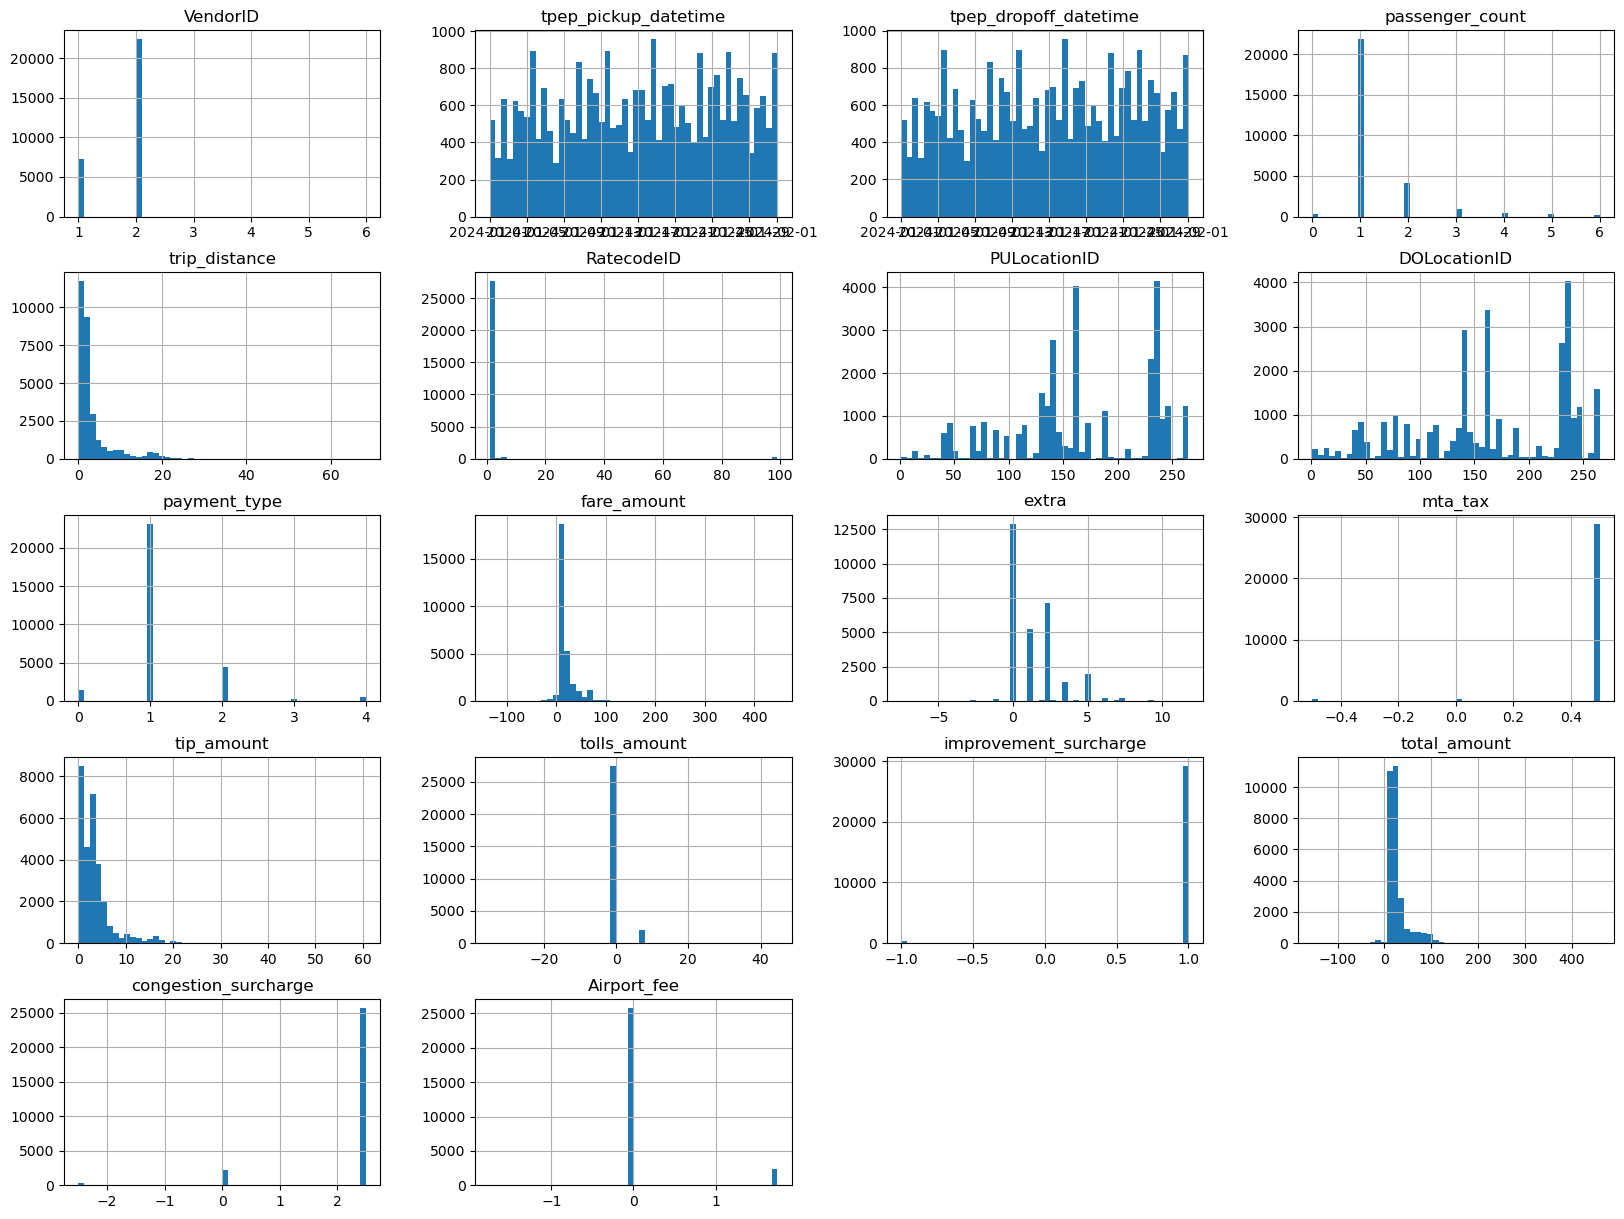

In [240]:
df.hist(bins=50, figsize=(20,15))
plt.show()

# Data Cleanning

In [20]:
print(df.duplicated().sum())

0


In [34]:
print(df.isnull().sum())

VendorID                    0
tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count          1402
trip_distance               0
RatecodeID               1402
store_and_fwd_flag       1402
PULocationID                0
DOLocationID                0
payment_type                0
fare_amount                 0
extra                       0
mta_tax                     0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
congestion_surcharge     1402
Airport_fee              1402
dtype: int64


In [174]:
# drop unwanted columns
df_drop_unwanted = df.drop(columns=['RatecodeID', 'store_and_fwd_flag'])

# fill na with means
fill_values = {
    'passenger_count': df['passenger_count'].mean(),  
    'congestion_surcharge': df['congestion_surcharge'].mean(),
    'Airport_fee': df['Airport_fee'].mean(),
}

df_clean = df_drop_unwanted.fillna(fill_values) 

In [175]:
print(df_clean.isnull().sum())

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
Airport_fee              0
dtype: int64


In [223]:
# 1. Remove the outliers of trip distance
print(df_clean['trip_distance'])

0          1.72
100        2.16
200        1.60
300        0.69
400        0.97
           ... 
2964200    0.00
2964300    0.83
2964400    2.96
2964500    2.80
2964600    4.20
Name: trip_distance, Length: 29647, dtype: float64


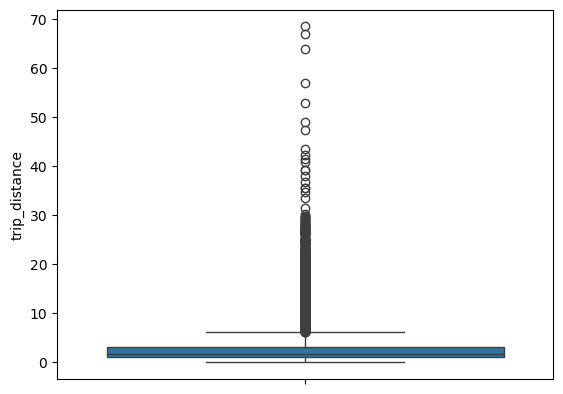

In [221]:
sns.boxplot(y=df_clean['trip_distance'])
plt.show()


In [222]:
#calculating trip distance values at each percntile 0-100
for i in range(0,100,10):
    var = df_clean["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 0.61
20 percentile value is 0.89
30 percentile value is 1.1
40 percentile value is 1.38
50 percentile value is 1.68
60 percentile value is 2.07
70 percentile value is 2.65
80 percentile value is 3.87
90 percentile value is 8.65
100 percentile value is  68.46


In [178]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = df_clean["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 8.65
91 percentile value is 9.31
92 percentile value is 10.0
93 percentile value is 10.71
94 percentile value is 11.74
95 percentile value is 14.13
96 percentile value is 16.66
97 percentile value is 17.56
98 percentile value is 18.44
99 percentile value is 20.02
100 percentile value is  68.46


In [179]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = df_clean["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 20.02
99.1 percentile value is 20.25
99.2 percentile value is 20.54
99.3 percentile value is 20.8
99.4 percentile value is 21.09
99.5 percentile value is 21.68
99.6 percentile value is 22.3
99.7 percentile value is 24.25
99.8 percentile value is 26.33
99.9 percentile value is 28.87
100 percentile value is  68.46


In [180]:
threshold = df_clean['trip_distance'].quantile(0.999)

# filter the data
df_filtered = df_clean[df_clean['trip_distance'] <= threshold]

# check if had done it right
print(df_filtered['trip_distance'].describe())

count    29617.000000
mean         3.222010
std          4.242976
min          0.000000
25%          1.000000
50%          1.680000
75%          3.100000
max         28.710000
Name: trip_distance, dtype: float64


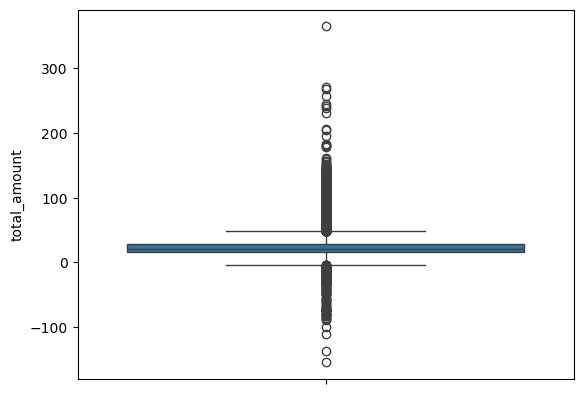

In [224]:
# 2. Remove the outliners for total fare
sns.boxplot(y="total_amount", data =df_filtered)
plt.show()

In [225]:
#calculating trip distance values at each percntile 0-100
for i in range(0,100,10):
    var = df_filtered["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -154.1
10 percentile value is 12.6
20 percentile value is 14.4
30 percentile value is 16.3
40 percentile value is 18.0
50 percentile value is 20.02
60 percentile value is 22.65
70 percentile value is 26.1
80 percentile value is 32.25
90 percentile value is 54.69
100 percentile value is  364.2


In [170]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = df_filtered["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 54.69
91 percentile value is 59.93
92 percentile value is 64.39
93 percentile value is 69.49
94 percentile value is 74.34
95 percentile value is 80.19
96 percentile value is 85.94
97 percentile value is 91.68
98 percentile value is 98.88
99 percentile value is 103.79
100 percentile value is  364.2


In [172]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = df_filtered["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 103.79
99.1 percentile value is 104.88
99.2 percentile value is 105.22
99.3 percentile value is 105.63
99.4 percentile value is 107.69
99.5 percentile value is 110.25
99.6 percentile value is 117.0
99.7 percentile value is 123.25
99.8 percentile value is 131.45
99.9 percentile value is 145.31
100 percentile value is  364.2


In [173]:
threshold = df_filtered['total_amount'].quantile(0.999)

# filter the data
df_filtered_with_fare = df_filtered[df_filtered['total_amount'] <= threshold]

# check if had done it right
print(df_filtered_with_fare['total_amount'].describe())

count    29587.000000
mean        26.656049
std         21.450345
min       -154.100000
25%         15.400000
50%         20.020000
75%         28.560000
max        144.550000
Name: total_amount, dtype: float64


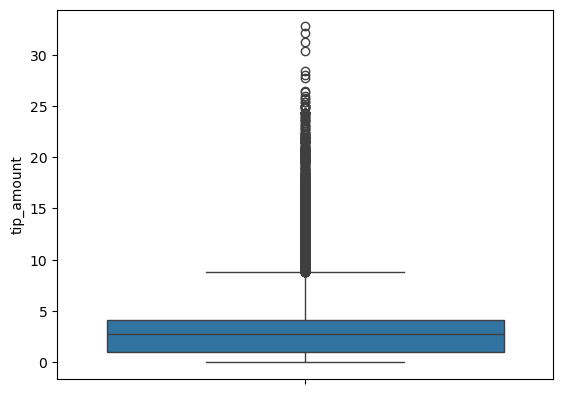

0 percentile value is -154.1
10 percentile value is 12.6
20 percentile value is 14.4
30 percentile value is 16.3
40 percentile value is 18.0
50 percentile value is 20.02
60 percentile value is 22.61
70 percentile value is 26.04
80 percentile value is 32.2
90 percentile value is 54.19
100 percentile value is  144.55
90 percentile value is 54.19
91 percentile value is 59.38
92 percentile value is 64.09
93 percentile value is 69.0
94 percentile value is 74.0
95 percentile value is 79.65
96 percentile value is 85.75
97 percentile value is 90.94
98 percentile value is 97.69
99 percentile value is 102.92
100 percentile value is  144.55
0 percentile value is -154.1
1 percentile value is -10.2
2 percentile value is 8.4
3 percentile value is 9.8
4 percentile value is 10.5
5 percentile value is 10.92
6 percentile value is 11.27
7 percentile value is 11.76
8 percentile value is 11.9
9 percentile value is 12.2
100 percentile value is  144.55
99.0 percentile value is 102.92
99.1 percentile value is

In [282]:
# 3. Remove outlier in tip amount
sns.boxplot(y=df_filtered_with_fare['tip_amount'])
plt.show()

#calculating trip distance values at each percntile 0-100
for i in range(0,100,10):
    var = df_filtered_with_fare["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = df_filtered_with_fare["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

for i in range(0,10):
    var = df_filtered_with_fare["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = df_filtered_with_fare["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

In [283]:
# there is outliers both in the upper end and the lower end
upper_threshold = df_filtered_with_fare['total_amount'].quantile(0.999)
lower_threshold = df_filtered_with_fare['total_amount'].quantile(0.01)

df_filtered_with_tip = df_filtered_with_fare[
    (df_filtered_with_fare['total_amount'] >= lower_threshold) & 
    (df_filtered_with_fare['total_amount'] <= upper_threshold)
]

print(df_filtered_with_tip['total_amount'].describe())

count    29262.000000
mean        27.099162
std         20.400007
min        -10.200000
25%         15.480000
50%         20.150000
75%         28.640000
max        131.400000
Name: total_amount, dtype: float64


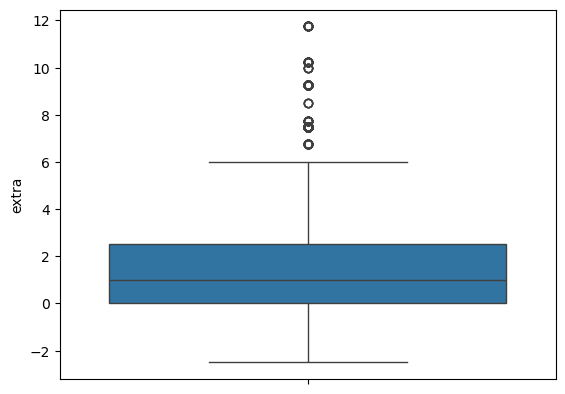

0 percentile value is -2.5
10 percentile value is 0.0
20 percentile value is 0.0
30 percentile value is 0.0
40 percentile value is 0.0
50 percentile value is 1.0
60 percentile value is 1.0
70 percentile value is 2.5
80 percentile value is 2.5
90 percentile value is 3.5
100 percentile value is  11.75
90 percentile value is 3.5
91 percentile value is 4.25
92 percentile value is 5.0
93 percentile value is 5.0
94 percentile value is 5.0
95 percentile value is 5.0
96 percentile value is 5.0
97 percentile value is 5.0
98 percentile value is 6.0
99 percentile value is 7.5
100 percentile value is  11.75


In [287]:
# 4. Remove outlier in extra

sns.boxplot(y=df_filtered_with_tip['extra'])
plt.show()

for i in range(0,100,10):
    var = df_filtered_with_tip["extra"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

for i in range(90,100):
    var = df_filtered_with_tip["extra"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

# According to the results, there is no significant outliers detected.

# Data Visualization

In [288]:
# create new features for pickup hour and pickup weekday
df_filtered_with_tip.loc[:,'pickup_hour'] = df_filtered_with_tip['tpep_pickup_datetime'].dt.hour
df_filtered_with_tip.loc[:,'pickup_weekday'] = df_filtered_with_tip['tpep_pickup_datetime'].dt.weekday

In [235]:
# Load the taxi zone look up file to map the location ID into actual location names
zone_mapping = pd.read_csv('E:/Goldsmiths/machinelearning/taxi_zone_lookup.csv')
print(zone_mapping.columns)

Index(['LocationID', 'Borough', 'Zone', 'service_zone'], dtype='object')


In [289]:
df_merge_PU = df_filtered_with_tip.merge(
    zone_mapping[['LocationID', 'Zone', 'Borough']],
    left_on='PULocationID',
    right_on='LocationID',
    how='left',
    suffixes=('_PU', '_DO')
)
df_merge_PU.rename(columns={'Zone_PU': 'PU_Zone', 'Borough_PU': 'PU_Borough'}, inplace=True)

In [290]:
df_merge_DO = df_merge_PU.merge(
    zone_mapping[['LocationID', 'Zone', 'Borough']],
    left_on='DOLocationID',
    right_on='LocationID',
    how='left',
    suffixes=('_PU', '_DO')
)
df_merge_DO.rename(columns={'Zone_DO': 'DO_Zone', 'Borough_DO': 'DO_Borough'}, inplace=True)

In [50]:
df_merge_DO.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,Airport_fee,LocationID_PU,Zone_PU,Borough_PU,LocationID_DO,DO_Zone,DO_Borough,LocationID,Zone,Borough
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,...,0.0,186,Penn Station/Madison Sq West,Manhattan,186,Penn Station/Madison Sq West,Manhattan,79,East Village,Manhattan
1,2,2024-01-01 00:18:24,2024-01-01 00:30:39,1.0,2.16,1.0,N,249,232,4,...,0.0,249,West Village,Manhattan,249,West Village,Manhattan,232,Two Bridges/Seward Park,Manhattan
2,1,2024-01-01 00:43:28,2024-01-01 00:56:45,1.0,1.60,1.0,N,161,263,1,...,0.0,161,Midtown Center,Manhattan,161,Midtown Center,Manhattan,263,Yorkville West,Manhattan
3,2,2024-01-01 00:14:36,2024-01-01 00:19:20,1.0,0.69,1.0,N,224,4,2,...,0.0,224,Stuy Town/Peter Cooper Village,Manhattan,224,Stuy Town/Peter Cooper Village,Manhattan,4,Alphabet City,Manhattan
4,2,2024-01-01 00:50:26,2024-01-01 00:57:56,1.0,0.97,1.0,N,236,75,2,...,0.0,236,Upper East Side North,Manhattan,236,Upper East Side North,Manhattan,75,East Harlem South,Manhattan


In [11]:
# Check if the merge is right
is_duplicate = zone_mapping['LocationID'].duplicated().sum()
print(f"Number of duplicate LocationIDs: {is_duplicate}") 

Number of duplicate LocationIDs: 0


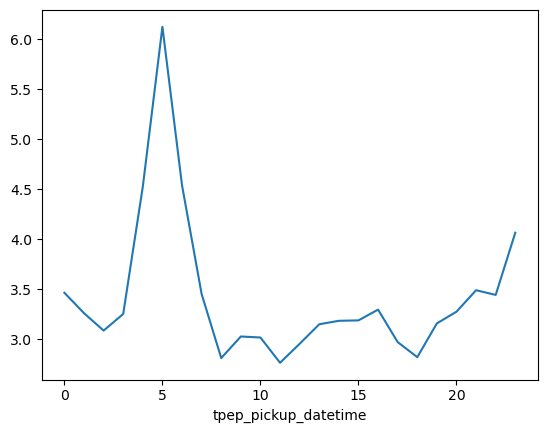

In [229]:
# Plot data over time to spot trends
# the trip distance ranges within a day
df_merge_DO.groupby(df_merge_DO['tpep_pickup_datetime'].dt.hour)['trip_distance'].mean().plot(kind='line')
plt.show()

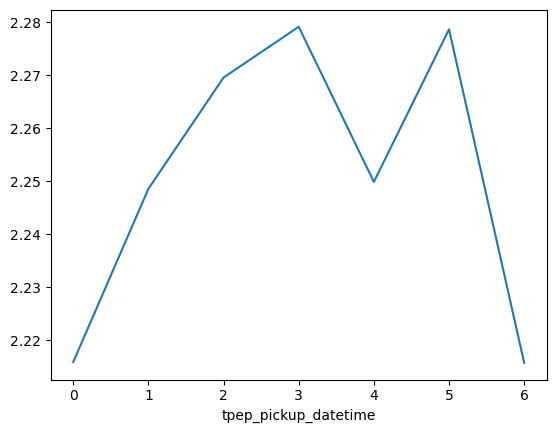

In [230]:
# congestions ranges within a day
df_merge_DO.groupby(df_merge_DO['tpep_pickup_datetime'].dt.weekday)['congestion_surcharge'].mean().plot(kind='line')
plt.show()

In [232]:
# the busiest weekday in different zone
mean_weekday_by_zone = df_merge_DO.groupby('Zone_PU')['pickup_weekday'].mean()
print(mean_weekday_by_zone)

Zone_PU
Allerton/Pelham Gardens    3.000000
Alphabet City              4.161290
Astoria                    3.117647
Auburndale                 1.000000
Baisley Park               2.857143
                             ...   
Woodlawn/Wakefield         2.000000
Woodside                   3.000000
World Trade Center         2.868421
Yorkville East             2.628429
Yorkville West             2.953528
Name: pickup_weekday, Length: 196, dtype: float64


In [234]:
# the busiest hour in different zone
mean_weekday_by_zone = df_merge_DO.groupby('Zone_PU')['pickup_hour'].mean()
print(mean_weekday_by_zone)

Zone_PU
Allerton/Pelham Gardens     6.666667
Alphabet City               8.677419
Astoria                    10.235294
Auburndale                 15.000000
Baisley Park               13.285714
                             ...    
Woodlawn/Wakefield          6.000000
Woodside                    7.800000
World Trade Center         15.096491
Yorkville East             12.593516
Yorkville West             13.495697
Name: pickup_hour, Length: 196, dtype: float64


In [58]:
# Group by Borough and calculate statistics
traffic_by_borough = df_merge_DO.groupby('Zone_PU')['trip_distance'].mean()  # Get the average trip distance per borough
print(traffic_by_borough)

Zone_PU
Allerton/Pelham Gardens     4.400000
Alphabet City               3.062258
Astoria                     3.365294
Auburndale                  5.460000
Baisley Park                9.950000
                             ...    
Woodlawn/Wakefield         12.000000
Woodside                    4.178000
World Trade Center          3.760088
Yorkville East              2.193392
Yorkville West              2.331443
Name: trip_distance, Length: 197, dtype: float64


In [237]:
# load the shape file to visualize the business of each zone on the map
shapefile_path = 'E:/Goldsmiths/machinelearning/taxi_zones/taxi_zones.shp'
taxi_zones = gpd.read_file(shapefile_path)

In [61]:
print(taxi_zones.head())

   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.770 256767.698, 1026495.593 ...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.310 144283.336, 936046.565 14...  


In [62]:
print(taxi_zones.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int64   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int64   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 14.5+ KB
None


In [218]:
# Ensure correct data types
df_merge_DO['LocationID_PU'] = df_merge_DO['LocationID_PU'].astype(int)
# Merge with the shapefile to get geometry information
merged_data = df_merge_DO.merge(taxi_zones[['LocationID', 'geometry']], left_on='LocationID_PU', right_on='LocationID', how='left')
# Create a DataFrame with the trip counts
trip_counts_df = pd.DataFrame({'Zone_PU': zone_trip_counts.index, 'trip_counts': zone_trip_counts.values})

# Merge with the GeoDataFrame
merged_with_counts = merged_data.merge(trip_counts_df, left_on='Zone_PU', right_on='Zone_PU', how='left')

# Ensure it's a GeoDataFrame with a valid geometry column
if not isinstance(merged_with_counts, gpd.GeoDataFrame):
    merged_with_counts = gpd.GeoDataFrame(merged_with_counts, geometry='geometry')

print(merged_with_counts.head())

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2024-01-01 00:57:55   2024-01-01 01:17:43              1.0   
1         2  2024-01-01 00:18:24   2024-01-01 00:30:39              1.0   
2         1  2024-01-01 00:43:28   2024-01-01 00:56:45              1.0   
3         2  2024-01-01 00:14:36   2024-01-01 00:19:20              1.0   
4         2  2024-01-01 00:50:26   2024-01-01 00:57:56              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.72         1.0                  N           186            79   
1           2.16         1.0                  N           249           232   
2           1.60         1.0                  N           161           263   
3           0.69         1.0                  N           224             4   
4           0.97         1.0                  N           236            75   

   payment_type  ...  pickup_weekday  LocationID_PU  \
0             2  ..

<Figure size 1000x800 with 0 Axes>

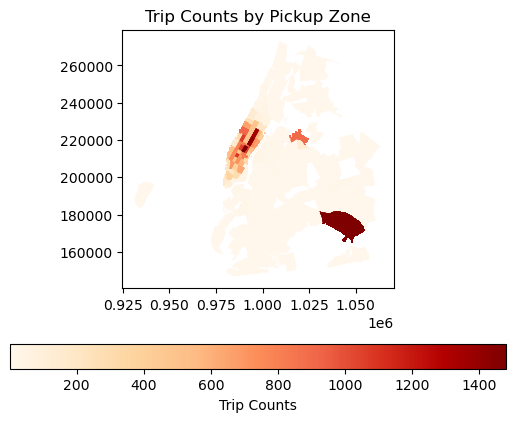

In [211]:
# Ensure the data is a GeoDataFrame
if not isinstance(merged_data, gpd.GeoDataFrame):
    merged_data = gpd.GeoDataFrame(merged_data, geometry='geometry')

# Plot the map
plt.figure(figsize=(10, 8))
# Use 'trip_counts' to determine the color of each zone
merged_with_counts.plot(column='trip_counts', cmap='OrRd', legend=True, legend_kwds={'label': "Trip Counts", 'orientation': "horizontal"})
plt.title("Trip Counts by Pickup Zone")
plt.show()


<Figure size 1000x800 with 0 Axes>

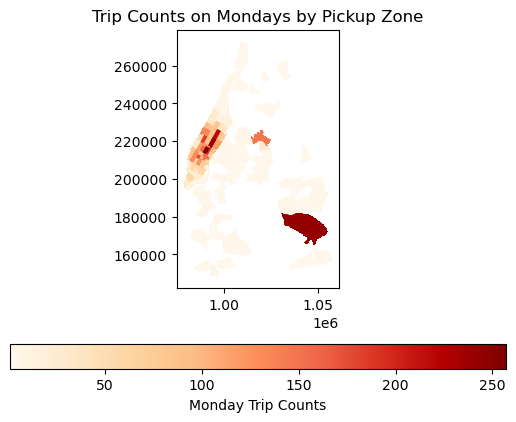

In [217]:
# Filter the data for weekends
Monday_data = merged_with_counts[merged_with_counts['pickup_weekday'] == 1]
# Calculate trip counts for weekend trips
Monday_trip_counts = Monday_data['Zone_PU'].value_counts()
# Create a DataFrame with the weekend trip counts
Monday_trip_counts_df = pd.DataFrame({'Zone_PU': Monday_trip_counts.index, 'Monday_trip_counts': Monday_trip_counts.values})

# Merge with the GeoDataFrame
merged_with_Monday_counts = merged_with_counts.merge(Monday_trip_counts_df, left_on='Zone_PU', right_on='Zone_PU', how='left')
# Ensure it's a GeoDataFrame with valid geometry
if not isinstance(merged_with_Monday_counts, gpd.GeoDataFrame):
    merged_with_Monday_counts = gpd.GeoDataFrame(merged_with_Monday_counts, geometry='geometry')

# Plot the map with trip counts for weekends
plt.figure(figsize=(10, 8))
merged_with_Monday_counts.plot(
    column='Monday_trip_counts',  # Use weekend trip counts
    cmap='OrRd',
    legend=True,
    legend_kwds={'label': "Monday Trip Counts", 'orientation': "horizontal"},
)
plt.title("Trip Counts on Mondays by Pickup Zone")
plt.show()


In [291]:
# According to the EDA results, choose the relevant features to train the model
X = df_merge_DO[['pickup_hour','pickup_weekday','trip_distance','tip_amount','extra']]
y = df_merge_DO['total_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [250]:
def display_scores(y_train, predictions):
    mae = mean_absolute_error(y_train, predictions)
    print("Mean Absolute Error (MAE):", mae)
    mse = mean_squared_error(y_train, predictions)
    print("Mean Squared Error (MSE):", mse)
    rmse = mse**0.5
    print("Root Mean Squared Error (RMSE):", rmse)
    r2 = r2_score(y_train, predictions)
    print("R-squared:", r2)

## Model 1: Linear Regression

In [292]:
lin = LinearRegression()
lin.fit(X_train, y_train)

LinearRegression()

In [293]:
predictions = lin.predict(X_train)
display_scores(y_train, predictions)

Mean Absolute Error (MAE): 3.423541696638859
Mean Squared Error (MSE): 47.74557625432914
Root Mean Squared Error (RMSE): 6.909817382125894
R-squared: 0.8837657137355027


In [356]:
mae_scorer = make_scorer(mean_absolute_error)
scores = cross_val_score(lin, X_train, y_train, cv=5, scoring=mae_scorer)

print("Cross-Validation Scores (MAE):", scores)
print("Mean MAE across folds:", np.mean(scores))

Cross-Validation Scores (MAE): [3.35814769 3.55109772 3.49284897 3.40825737 3.31049779]
Mean MAE across folds: 3.4241699047061593


|Model|RMSE|MAE|RMSE|R-squared|Cross-Validation Scores|
| --- | --- | --- |---|---|---|
|Linear Regression| 3.42 | 47.7 | 6.9 | 0.88|3.42|

## Model 2: K-nearest Neighbour

In [294]:
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

In [295]:
predictions = neigh.predict(X_train)
display_scores(y_train, predictions)

Mean Absolute Error (MAE): 2.45767841624762
Mean Squared Error (MSE): 28.886617772640726
Root Mean Squared Error (RMSE): 5.374627221737404
R-squared: 0.9296769321305699


In [355]:
mae_scorer = make_scorer(mean_absolute_error)
scores = cross_val_score(neigh, X_train, y_train, cv=5, scoring=mae_scorer)

print("Cross-Validation Scores (MAE):", scores)
print("Mean MAE across folds:", np.mean(scores))

Cross-Validation Scores (MAE): [2.70617305 2.92668489 2.86551355 2.712427   2.63887964]
Mean MAE across folds: 2.7699356263920243


|Model|RMSE|MAE|RMSE|R-squared|Cross-Validation Score|
| --- | --- | --- |---|---|---|
|Linear Regression| 3.42 | 47.7 | 6.9 | 0.88|3.42
|K-nearest Neighbour|2.46|28.8|5.37|0.92|2.77

## Model 3: Random Forest

In [296]:
rf = RandomForestRegressor(n_estimators=1000)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

In [255]:
predictions = rf.predict(X_train)
display_scores(y_train, predictions)

Mean Absolute Error (MAE): 1.0638388421517828
Mean Squared Error (MSE): 11.561325161663461
Root Mean Squared Error (RMSE): 3.4001948711306915
R-squared: 0.9749199225897078


In [357]:
mae_scorer = make_scorer(mean_absolute_error)
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring=mae_scorer)

print("Cross-Validation Scores (MAE):", scores)
print("Mean MAE across folds:", np.mean(scores))

Cross-Validation Scores (MAE): [2.22170327 2.4920532  2.3724032  2.23241786 2.16380408]
Mean MAE across folds: 2.296476322965659


|Model|RMSE|MAE|RMSE|R-squared|Cross-Validation Score|
| --- | --- | --- |---|---|---|
|Linear Regression| 3.42 | 47.7 | 6.9 | 0.88|3.42
|K-nearest Neighbour|2.46|28.8|5.37|0.92|2.77
|Random Forest|1.06|11.56|3.4|0.97|2.35

## Model 4: Grid Search on Random Forest

In [340]:
param_grid = {
    'n_estimators': [500, 1000],  # tree number
    'max_features': ['log2', 'sqrt'],  # features for each tree
    'max_depth': [20, None],  # max depth for each tree
}

# Grid Search for best parameters
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 1000}


In [341]:
predictions = grid_search.predict(X_train)
display_scores(y_train, predictions)

Mean Absolute Error (MAE): 1.0370728180331168
Mean Squared Error (MSE): 7.12687442157622
Root Mean Squared Error (RMSE): 2.669620651249203
R-squared: 0.9826499703914767


|Model|RMSE|MAE|RMSE|R-squared|Cross-Validation Score|
| --- | --- | --- |---|---|---|
|Linear Regression| 3.42 | 47.7 | 6.9 | 0.88|3.62
|K-nearest Neighbour|2.46|28.8|5.37|0.92|2.72
|Random Forest|1.06|11.56|3.4|0.97|2.35
|Random Forest with Grid Search|1.03|7.12|2.66|0.98|

## Model 5: XGBoost

In [300]:
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 500, alpha = 10, n_estimators = 1000)
xgb_reg.fit(X_train, y_train)


XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=500, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)

In [301]:
predictions = xgb_reg.predict(X_train)
display_scores(y_train, predictions)

Mean Absolute Error (MAE): 2.7646860712903707
Mean Squared Error (MSE): 33.15724507926085
Root Mean Squared Error (RMSE): 5.758232808706231
R-squared: 0.9192802973880653


In [358]:
mae_scorer = make_scorer(mean_absolute_error)
scores = cross_val_score(xgb_reg, X_train, y_train, cv=5, scoring=mae_scorer)

print("Cross-Validation Scores (MAE):", scores)
print("Mean MAE across folds:", np.mean(scores))

Cross-Validation Scores (MAE): [2.75596524 3.01266135 2.89655429 2.77566675 2.72232303]
Mean MAE across folds: 2.8326341317335393


|Model|RMSE|MAE|RMSE|R-squared|Cross-Validation Score|
| --- | --- | --- |---|---|---|
|Linear Regression| 3.42 | 47.7 | 6.9 | 0.88|3.62
|K-nearest Neighbour|2.46|28.8|5.37|0.92|2.72
|Random Forest|1.06|11.56|3.4|0.97|2.35
|Random Forest with Grid Search|1.03|7.12|2.66|0.98|
|XGBoost|2.76|33.15|5.75|0.91|2.83|

## Model 6: Random Search on XGBoost

In [361]:
param_dist = {
    'n_estimators': [500, 800, 1000],
    'max_depth': [10, 20],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'subsample': [0.8, 0.9, 1.0], 
}
# Use Random search to find the best parameter here
random_search = RandomizedSearchCV(xgb_reg, param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)


Best Parameters: {'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.2}


In [362]:
predictions = random_search.predict(X_train)
display_scores(y_train, predictions)

Mean Absolute Error (MAE): 2.759043610534217
Mean Squared Error (MSE): 33.12971682993695
Root Mean Squared Error (RMSE): 5.755841974024039
R-squared: 0.9193473135739257


|Model|RMSE|MAE|RMSE|R-squared|Cross-Validation Score|
| --- | --- | --- |---|---|---|
|Linear Regression| 3.42 | 47.7 | 6.9 | 0.88|3.62
|K-nearest Neighbour|2.46|28.8|5.37|0.92|2.72
|Random Forest|1.06|11.56|3.4|0.97|2.35
|Random Forest with Grid Search|1.03|7.12|2.66|0.98|
|XGBoost|2.76|33.15|5.75|0.91|2.83
|XGBoost with Random Search| 2.76|33.1|5.75|0.91

## Model 7: Neural Network

In [321]:
l1_regularization_strength = 0.01

def build_reg_model():
    reg_model = tf.keras.models.Sequential()
    reg_model.add(layers.Dense(512, activation='relu', 
                               input_shape=(X_train.shape[1],),
                               kernel_regularizer=regularizers.l1(l1_regularization_strength)))
    reg_model.add(layers.Dense(256, activation='relu'))
    reg_model.add(layers.Dense(256, activation='relu'))
    #reg_model.add(layers.Dropout(0.05))
    reg_model.add(layers.Dense(1))
    reg_model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mae'])
    return reg_model

def train_model(reg_model):
    history = reg_model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.2)
    return history

reg_model = build_reg_model()
history = train_model(reg_model)

Epoch 1/100
129/129 [==============================] - 1s 4ms/step - loss: 107.2737 - mae: 5.4127 - val_loss: 38.7272 - val_mae: 3.0813
Epoch 2/100
129/129 [==============================] - 0s 3ms/step - loss: 43.6156 - mae: 3.1659 - val_loss: 39.2243 - val_mae: 3.2027
Epoch 3/100
129/129 [==============================] - 0s 3ms/step - loss: 42.2190 - mae: 3.1511 - val_loss: 35.8401 - val_mae: 3.0955
Epoch 4/100
129/129 [==============================] - 0s 3ms/step - loss: 39.8009 - mae: 3.0175 - val_loss: 37.5220 - val_mae: 3.3193
Epoch 5/100
129/129 [==============================] - 0s 3ms/step - loss: 39.1633 - mae: 3.0123 - val_loss: 35.9709 - val_mae: 3.3994
Epoch 6/100
129/129 [==============================] - 0s 3ms/step - loss: 38.8450 - mae: 3.0561 - val_loss: 31.5533 - val_mae: 2.6793
Epoch 7/100
129/129 [==============================] - 0s 3ms/step - loss: 37.8660 - mae: 2.9983 - val_loss: 30.8473 - val_mae: 2.8454
Epoch 8/100
129/129 [==============================] -

In [330]:
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.plot(epochs, loss, blue_dots, label = 'Training loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_mae(history):
    mae = history.history['mae']
    val_mae = history.history['val_mae']

    epochs = range(1, len(mae) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.plot(epochs, mae, blue_dots, label = 'Training mae')
    plt.plot(epochs, val_mae, solid_blue_line, label = 'Validation mae')
    plt.title('Training and validation Mae')
    plt.xlabel('Epochs')
    plt.ylabel('Mae')
    plt.legend()
    plt.show()

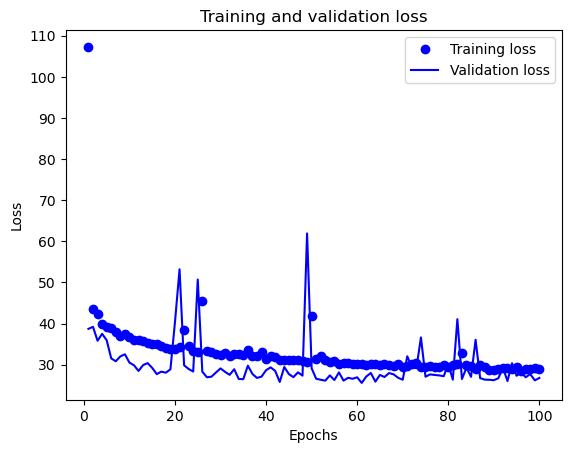

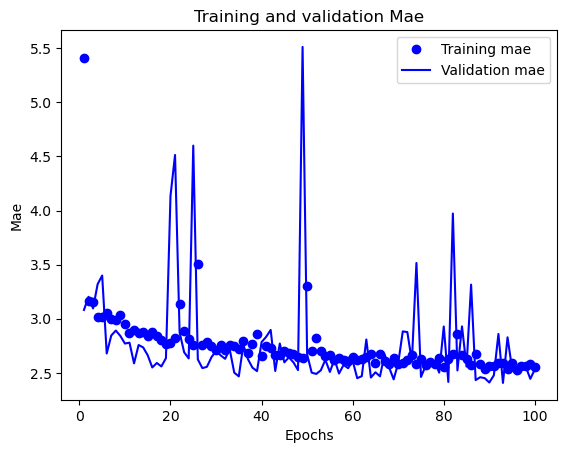

In [331]:
plot_loss(history)
plot_mae(history)

## Model 8: Automatic Tuner on Neural Network

In [333]:
import kerastuner as kt
from tensorflow import keras

# Use neural network
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 5)):  
        model.add(keras.layers.Dense(
            units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
            activation='relu'
        ))
    model.add(keras.layers.Dropout(rate=hp.Float('dropout', 0.2, 0.5, step=0.1)))   
    model.add(keras.layers.Dense(1))      
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mean_squared_error',  
        metrics=['mae']  
    )

    return model
    
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',  
    max_epochs=10,  
    factor=3,  
    directory='kt_tuning',  
    project_name='regression_tuning'  
)


tuner.search_space_summary()
tuner.search(X_train, y_train, validation_split=0.2, epochs=10)
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparamters:", best_hyperparameters.values)


Trial 30 Complete [00h 00m 09s]
val_loss: 31.484180450439453

Best val_loss So Far: 27.658138275146484
Total elapsed time: 00h 03m 05s
Best Hyperparamters: {'num_layers': 2, 'units_0': 448, 'units_1': 416, 'dropout': 0.2, 'learning_rate': 0.0021861497732584595, 'units_2': 320, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0015', 'units_3': 96, 'units_4': 480}


In [1]:
# I tried Keras Tuner on the neural network, but the performance is not the best.

# Finalize the model

In [363]:
predictions = grid_search.predict(X_test)
display_scores(y_test, predictions)

Mean Absolute Error (MAE): 2.187749417541635
Mean Squared Error (MSE): 28.070417836604538
Root Mean Squared Error (RMSE): 5.2981523040211425
R-squared: 0.9345180567842989


In [384]:
# Assume these are the features used during model training
training_features = ['pickup_hour', 'pickup_weekday', 'trip_distance', 'tip_amount', 'extra']

# Function to suggest the best zone
def suggest_best_zone_and_income(grid_search, pickup_hour, pickup_weekday, zone_mapping):
    # Create sample data with default values for all required features
    default_trip_distance = 2.0  # Default value, adjust as needed
    default_tip_amount = 1.0  # Default value, adjust as needed
    default_extra = 0.5  # Default value, adjust as needed
    
    # Create sample data with required features
    sample_data = pd.DataFrame({
        'pickup_hour': [pickup_hour] * len(zone_mapping),
        'pickup_weekday': [pickup_weekday] * len(zone_mapping),
        'trip_distance': [default_trip_distance] * len(zone_mapping),
        'tip_amount': [default_tip_amount] * len(zone_mapping),
        'extra': [default_extra] * len(zone_mapping),
    })

    # Predict expected fare for each zone
    predicted_fares = grid_search.predict(sample_data)

    # Get the best zone with the highest expected fare
    best_zone_index = predicted_fares.argmax()  # Index of the highest fare
    best_zone = zone_mapping.loc[best_zone_index, 'Zone']
    estimated_income = predicted_fares[best_zone_index]  # Expected income

    return best_zone, estimated_income

# Example usage
pickup_hour = 9 # Example hour
pickup_weekday = 4  # Example weekday (4 for Tuesday)

best_zone, estimated_income = suggest_best_zone_and_income(grid_search, pickup_hour, pickup_weekday, zone_mapping)


print("Best zone to go to:", best_zone)
print("Estimated income (fare):", estimated_income)


Best zone to go to: Newark Airport
Estimated income (fare): 18.403046228350057
